# FFT Tutorial with `discretisedfield`

This Jupyter notebook is a tutorial guide for using the Fast Fourier Transform (FFT) functionality in `discretisedfield`. FFT is a highly efficient algorithm used to decompose a dataset into its base frequencies. In discretisedfield, our primary focus is on spatial transformations.

In this tutorial we explain the different methods to perform a FFT on a field by looking at a few examples.

## FFT examples

To get started, let's import the `discretisedfield` package.

In [1]:
import discretisedfield as df

As an example we study a cuboidal geometry with a helix propagating along the `z` direction with a $7\, \mathrm{nm}$ wavelength.

In [2]:
import numpy as np

mesh = df.Mesh(p1=(0, 0, 0), p2=(5e-9, 20e-9, 45e-9), cell=(1e-9, 1e-9, 1e-9))


def value(p):
    x, y, z = p
    k = 2 * np.pi / 7e-9
    return np.sin(k * z), np.cos(k * z), 0


field = df.Field(mesh, nvdim=3, value=value)
field

Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[5e-09, 2e-08, 4.5e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[5, 20, 45]), nvdim=3, vdims: (x, y, z))

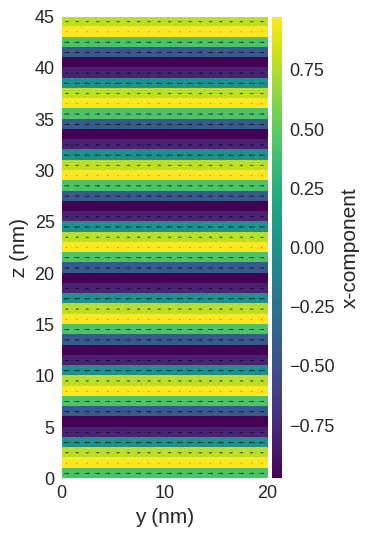

In [3]:
field.sel("x").mpl()

### FFT Methods

The `discretisedfield` package provides four different methods for performing Fast Fourier Transform (FFT) operations on a `discretisedfield.Field` object:

1. `fftn`: This is the "full" FFT method which computes the n-dimensional FFT. It returns the complex-valued FFT result that has the same shape as the input field. It's used when the full frequency spectrum is needed.

3. `ifftn`: This is the inverse of the "full" FFT method, which takes a complex-valued FFT result and computes the inverse FFT to return a field in the spatial domain. It's used to go back from the spatial frequency domain to the spatial domain.

3. `rfftn`: This stands for "real FFT". It's similar to `fftn`, but it only computes the non-negative frequency terms. The result is a complex-valued array that has half the size of the last dimension compared to the input. It's used when the input field only has real values, and hence its frequency spectrum is symmetric. Thus, it saves computation time and storage.

4. `irfftn`: This is the inverse of the "real FFT" method. It takes a half-sized complex-valued FFT result (as output by `rfftn`) and computes the inverse FFT to return a real-valued field in the spatial domain. It's used when the original field is known to be real-valued.

All of these methods are `n` dimensional and work with any number of value (vector) and mesh (geometric) dimensions. These four methods provide the necessary tools to perform FFT operations and allow the transition between the spatial domain and frequency domain, covering both real and complex-valued fields.

#### FFT
Now we can perform out first FFT.

In [4]:
fft_field = field.fftn()
fft_field

Field(Mesh(Region(pmin=[-500000000.0, -525000000.0, -499999999.99999994], pmax=[500000000.0, 475000000.0, 499999999.99999994], dims=['k_x', 'k_y', 'k_z'], units=['(m)$^{-1}$', '(m)$^{-1}$', '(m)$^{-1}$']), n=[5, 20, 45]), nvdim=3, vdims: (ft_x, ft_y, ft_z))

With the application of the FFT methods in `discretisedfield`, notable transformations occur in both the `mesh` and the `field`:

1. **Mesh Transformation**: The `mesh` is transposed from the regular space to the spatial frequency domain. As a consequence, the units transition from meters $(m)$ to inverse meters $\left((\mathrm{m})^{-1}\right)$. Furthermore, to signify this transformation, `k_` is prepended to each of the `dims` of the mesh. However, the Fourier transformed `mesh` maintains the same number of points (`n`) as the original mesh.

    NOTE: The values of the axis in Fourier space are frequency NOT angular frequency so DO NOT include a factor of $2\pi$. i.e. $|{\bf k}| = \frac{1}{\lambda} \neq \frac{2 \pi}{\lambda}$, where $\bf k$ is the wave vector and $\lambda$ is the wavelength.

2. **Field Transformation**: The field, although it continues to possess three value dimensions, undergoes a transformation, highlighted by the prefix `ft_` added to each dimension. This indicates that these dimensions have been processed through a Fourier Transform.

These changes not only assist in distinguishing the transformed quantities but also serve a practical purpose by providing the values in appropriate units and dimensions.

To visualise this Fourier transform we can plot the Power Spectral Density given by:

$$ PSD(k) = | F(k) |^2 $$

where:

- $PSD(k)$ represents the power spectral density at spatial frequency $k$.
- $F(k)$ represents the Fourier transform of the original signal at spatial frequency $k$.
- $|$ $|$ denotes the absolute value.

In essence, the PSD is the magnitude squared of the Fourier transform of the original signal, providing a measure of the power (or intensity) of the signal across the different spatial frequencies.

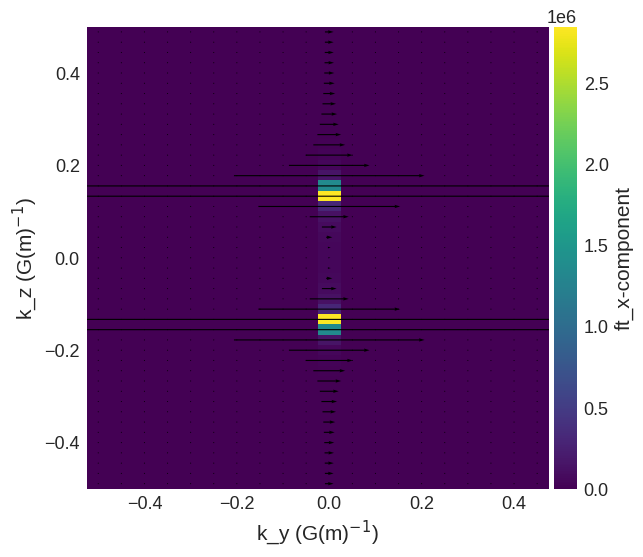

In [5]:
psd = np.power(np.abs(fft_field), 2)

psd.sel("k_x").mpl()

In this plot, we observe prominent peaks at $k_y = \pm 0.14\, (nm)^{-1}$ aligning with our expectations for a sinusoidal modulation with a wavelength of $7\, nm$ and confirms the presence of the anticipated spatial frequency in our data.

#### iFFT

Now we have a Fourier transformed field we can transform it back into real space by using an ifft.

In [6]:
ifft_field = fft_field.ifftn()
ifft_field

Field(Mesh(Region(pmin=[-2.5e-09, -1e-08, -2.2500000000000003e-08], pmax=[2.5e-09, 1e-08, 2.2500000000000003e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[5, 20, 45]), nvdim=3, vdims: (x, y, z))

Upon transforming our field back into the regular space, we observe several changes. Firstly, our units return to the meter ($m$) notation. Secondly, both the dimensions and the value dimensions revert to their original identifiers, removing the `k_` and `ft_` prefixes respectively. this reflects the transition from the frequency to the spatial domain. As expected, the total number of data points within the field remains constant.

However, one key aspect of Fourier transforms to be aware of is the loss of the original translation during the transformation process. Consequently, the Fourier transformed field or signal is inherently centred around the origin.

This characteristic is due to the Fourier transform operating in the frequency domain, which identifies the frequencies present in the signal but disregards the location or shift of those frequencies in the original signal. Hence, after the Fourier transform, the information about the original position of the frequencies in the spatial domain is lost and the resulting transformed signal is always centred around the origin.

However, we can `translate` the mesh to move the field back to the desired position `inplace`.

In [7]:
ifft_field.mesh.translate(field.mesh.region.centre, inplace=True)

Mesh(Region(pmin=[0.0, 0.0, -3.308722450212111e-24], pmax=[5e-09, 2e-08, 4.5000000000000006e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[5, 20, 45])

As a check we can see if our original field is the same as the field which has been Fourier transformed and then inverse Fourier transformed. By using the `allclose` method in the `Field` class we can see that the two field are almost the same.

In [8]:
field.allclose(ifft_field)

True

While our field has been transformed back into its original space, using the `==` operator reveals that the initial and final states are not identical.

In [9]:
field == ifft_field

False

This discrepancy stems primarily from two factors:

1. **Floating-Point Precision**: Arithmetic operations on floating-point numbers can lead to small imprecisions.

2. **Complex Values**: Initially, our field comprised real values. However, the processing via FFT and inverse FFT results in a field with complex values. 

These factors contribute to the subtle differences when comparing the original and transformed fields directly and shows how the `allclose` method can offer a more sutable comparison.

We can visualise these differences by plotting the real and imaginary parts.

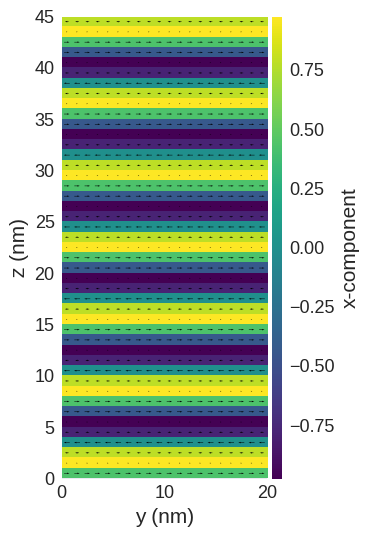

In [10]:
ifft_field.real.sel("x").mpl()

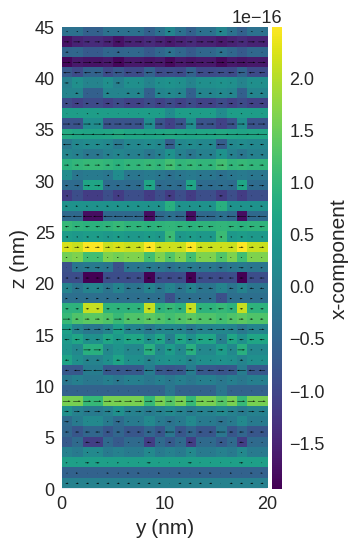

In [11]:
ifft_field.imag.sel("x").mpl()

As we can see, the real part of the inverse Fourier transformed field is almost identical to the original field, while the imaginary part is practically zero.

#### rFFT

As the original field we are using is real we can use a `rfft`. 

In [12]:
rfft_field = field.rfftn()
rfft_field

Field(Mesh(Region(pmin=[-500000000.0, -525000000.0, -11111111.11111111], pmax=[500000000.0, 475000000.0, 499999999.99999994], dims=['k_x', 'k_y', 'k_z'], units=['(m)$^{-1}$', '(m)$^{-1}$', '(m)$^{-1}$']), n=[5, 20, 23]), nvdim=3, vdims: (ft_x, ft_y, ft_z))

Lets also plot the PSD

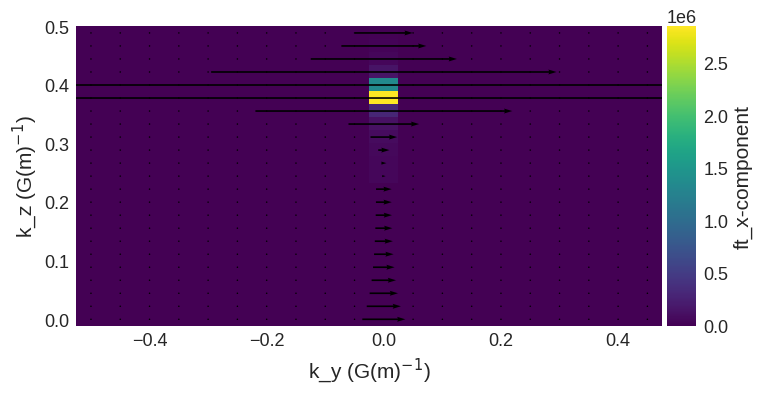

In [13]:
psd = np.power(np.abs(rfft_field), 2)

psd.sel("k_x").mpl()

We can see that the mesh and the plot look different for real Fourier transforms compared to full Fourier transforms. For real Fourier transforms, when the `mesh` is converted from the standard spatial domain to the spatial frequency domain. As before each dimension of the mesh (`dims`) is prepended with `k_` to signify this change. However, the Fourier transformed `mesh` no longer has the the same number of points (`n`) as the original mesh in all directions. In the final dimension, the number of points is reduced by half (If n is even, the length of the transformed axis is $(n/2)+1$. If n is odd, the length is $(n+1)/2$).

This halving is a result of the properties of real-valued functions, which have a symmetric Fourier Transform. As a result, it is sufficient to store only half of the frequency components (those for non-negative frequencies).

#### irfft
As we have an rFFT field we can convert this back to the spatial domain by using an irfft.

In [14]:
irfft_field = rfft_field.irfftn()
irfft_field

Field(Mesh(Region(pmin=[-2.5e-09, -1e-08, -2.2500000000000003e-08], pmax=[2.5e-09, 1e-08, 2.2500000000000003e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[5, 20, 44]), nvdim=3, vdims: (x, y, z))

As anticipated, the inverse transform function works effectively, yet the total number of points in the final geometric dimension of the mesh is one less than the original. This discrepancy arises due to the characteristics of grids with an odd number of cells. 

To reconcile this, we can explicitly specify the desired shape of the output while calling the `irfftn` function. This way, we ensure that the final transformed field aligns with the original field in terms of its dimensionality.

In [15]:
irfft_field = rfft_field.irfftn(shape=field.mesh.n)
irfft_field.mesh.translate(field.mesh.region.centre, inplace=True)
irfft_field

Field(Mesh(Region(pmin=[0.0, 0.0, -3.308722450212111e-24], pmax=[5e-09, 2e-08, 4.5000000000000006e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[5, 20, 45]), nvdim=3, vdims: (x, y, z))

Now we can use the `allclose` function to see that this is a good comparison to our original field.

In [16]:
field.allclose(irfft_field)

True

## Angular frequency

As we noted earlier, the values of the axis in Fourier space are frequency NOT angular frequency so DO NOT include a factor of $2\pi$. i.e. $|{\bf k}| = \frac{1}{\lambda} \neq \frac{2 \pi}{\lambda}$, where $\bf k$ is the wave vector and $\lambda$ is the wavelength. However, we can convert the mesh into angular frequency.

First we will perform a new Fourier transform and plot the PSD.

In [17]:
fft_field_freq = field.fftn()

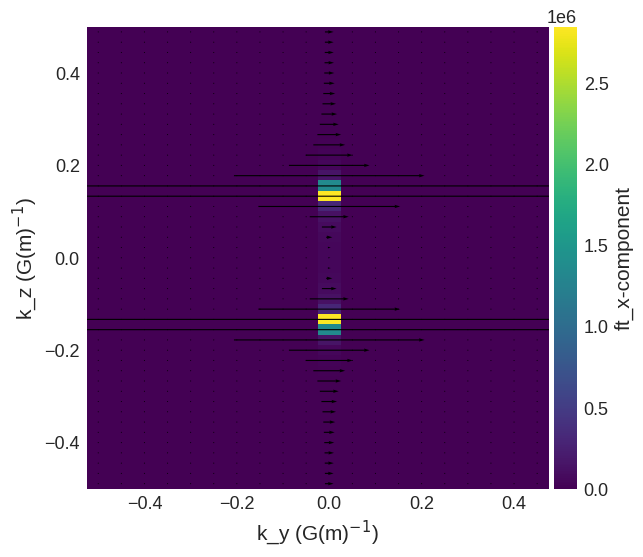

In [18]:
psd = np.power(np.abs(fft_field_freq), 2)

psd.sel("k_x").mpl()

We can convert to angular frequency using two methods. We can either introduce a new field or modify the existing field directly. In this explanation, we'll demonstrate the more straightforward approach of modifying the field directly. To achieve this, we can scale the mesh by a factor of $2\pi$.

In [19]:
fft_field_freq.mesh.scale(2 * np.pi, inplace=True)

Mesh(Region(pmin=[-3141592653.589793, -3166592653.589793, -3141592653.5897927], pmax=[3141592653.589793, 3116592653.589793, 3141592653.5897927], dims=['k_x', 'k_y', 'k_z'], units=['(m)$^{-1}$', '(m)$^{-1}$', '(m)$^{-1}$']), n=[5, 20, 45])

Plotting the PSD of the field again, we can see that the axis have expanded by a factor of $2\pi$. 

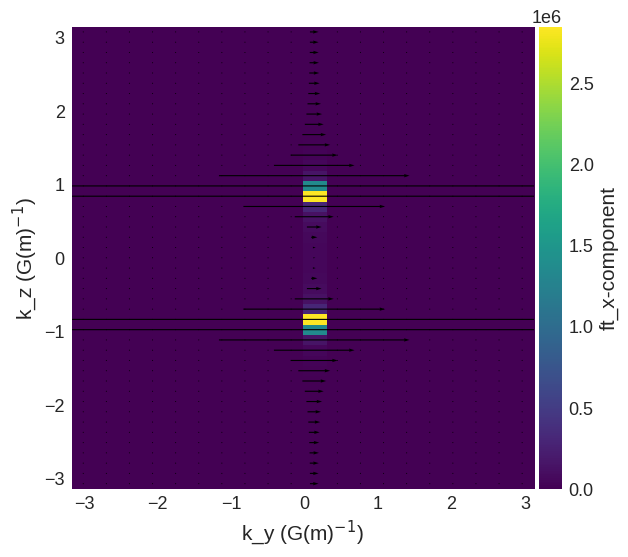

In [20]:
psd = np.power(np.abs(fft_field_freq), 2)

psd.sel("k_x").mpl()